Install dependencies

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached PyVirtualDisplay-0.2.5-py2.py3-none-any.whl (13 kB)
  Using cached PyOpenGL-3.1.5-py3-none-any.whl (2.4 MB)
  Using cached PyOpenGL_accelerate-3.1.5-cp39-cp39-linux_x86_64.whl
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/lucyannofrota/anaconda3/envs/APA/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-lh3qfp8c/box2d-py_1d41d396c7d14743a9ad5d6d667821ee/setup.py'"'"'; __file__='"'"'/tmp/pip-install-lh3qfp8c/box2d-py_1d41d396c7d14743a9ad5d6d667821ee/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code

In [2]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import Video
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import sys
Running_in_colab = 'google.colab' in sys.modules

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

from PartI_lib import archs as archs
from PartI_lib import performance_evaluation as eval
from PartI_lib import train_loop as tl
from PartI_lib import my_tools as mt
# !mkdir Checkpoints
import time


True
cuda:0


In [3]:
#@title Deep RL Replay Buffer

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 20 consecutive trials.

In [4]:
#@title DQN movie generation (for visual evaluation in Google Colab)

def createMovie(Network,path,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env,path+'/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob(path+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        if(Running_in_colab):
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            # print("Loc Video")
            # print(mp4)
            # print("VIDEO PR")
            Video(mp4)

            # HTML("""
            #         <video alt="test" controls>
            #             <source src="test.mp4" type="video/mp4">
            #         </video>
            #     """)
    else: 
        print("Could not find video")

In [5]:
# from IPython.display import HTML

# Video("openaigym.video.19.10825.video000000.mp4")
# HTML('<iframe width="560" height="315" src="openaigym.video.19.10825.video000000.mp4" frameborder="0" allowfullscreen></iframe>')

Run the new netwwork with random policy

In [6]:
# randomnet=RandomNet(2)
# createMovie(randomnet,"random")

Initialization and Parameters:


DQN_128_1_001_2e-03_099_1e-02_097
0 of 2000
14.0 14 14.0
31.0 31 22.5
40.0 40 19.46153846153846
25 of 2000
49.0 49 20.65
50 of 2000
50.0 50 18.8
75 of 2000
50.0 50 22.5
100 of 2000
54.0 54 21.05
125 of 2000
150 of 2000
56.0 56 25.55
70.0 70 25.85
175 of 2000
77.0 77 36.75
79.0 79 41.35
200 of 2000
114.0 114 39.4
225 of 2000
250 of 2000
117.0 117 64.95
117.0 117 63.95
275 of 2000
135.0 135 52.45
156.0 156 57.95
191.0 191 64.95
200.0 200 77.5
300 of 2000
325 of 2000
200.0 200 60.1
350 of 2000
200.0 200 88.05
200.0 200 89.15
200.0 200 84.05
375 of 2000
200.0 200 85.7
200.0 200 92.0
400 of 2000
200.0 200 83.4
200.0 200 90.55
200.0 200 96.9
425 of 2000
200.0 200 115.9
200.0 200 108.1
200.0 200 95.8
450 of 2000
200.0 200 105.55
200.0 200 115.7
200.0 200 116.05
200.0 200 123.5
200.0 200 128.6
200.0 200 134.6
200.0 200 139.0
200.0 200 143.0
200.0 200 143.0
200.0 200 145.45
200.0 200 150.3
200.0 200 150.3
200.0 200 159.05
475 of 2000
200.0 200 159.05
200.0 200 167.3
200.0 200 173.45
200.0 200 1

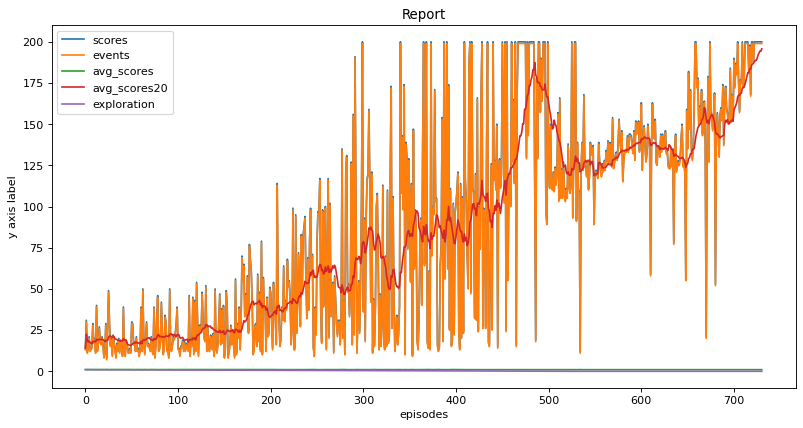

Could not find video
DQN_128_1_001_2e-03_099_1e-03_097
0 of 2000
91.0 91 91.0
25 of 2000
50 of 2000
75 of 2000
100 of 2000
93.0 93 28.05
125 of 2000
149.0 149 34.25
150 of 2000
165.0 165 50.4
175 of 2000
200 of 2000
167.0 167 61.5
189.0 189 63.85
200.0 200 69.55
225 of 2000
200.0 200 76.15
250 of 2000
200.0 200 98.2
200.0 200 101.8
200.0 200 107.2
200.0 200 111.75
200.0 200 120.4
275 of 2000
200.0 200 110.45
200.0 200 118.6
200.0 200 126.05
200.0 200 131.15
200.0 200 146.4
200.0 200 148.45
200.0 200 150.1
200.0 200 155.25
300 of 2000
200.0 200 132.55
200.0 200 135.7
200.0 200 138.3
200.0 200 137.0
200.0 200 133.05
200.0 200 137.15
200.0 200 139.3
200.0 200 138.85
200.0 200 136.8
325 of 2000
200.0 200 116.4
200.0 200 123.3
200.0 200 124.05
200.0 200 123.0
200.0 200 126.1
200.0 200 132.2
200.0 200 138.3
350 of 2000
200.0 200 134.4
200.0 200 133.5
200.0 200 134.75
200.0 200 134.95
200.0 200 132.65
200.0 200 126.5
200.0 200 134.5
200.0 200 139.8
200.0 200 146.25
200.0 200 151.8
200.0 200 1

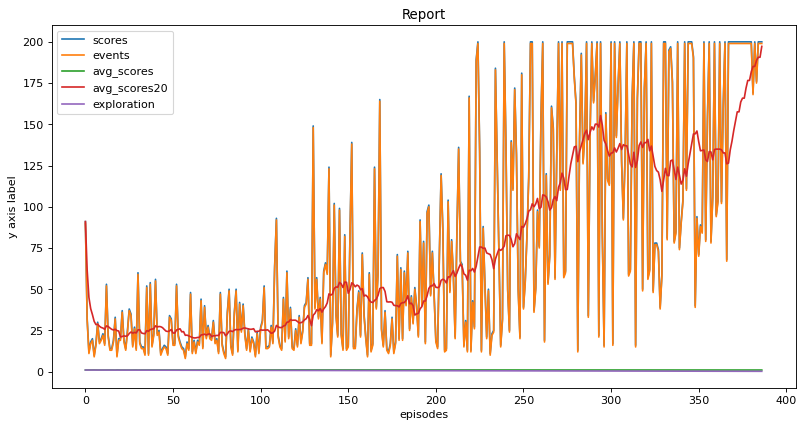

Could not find video
DQN_128_1_001_2e-03_099_1e-04_097
0 of 2000
14.0 14 14.0
43.0 43 22.666666666666668
25 of 2000
48.0 48 24.9
50 of 2000
50.0 50 25.15
79.0 79 27.65
84.0 84 37.2
75 of 2000
118.0 118 39.25
100 of 2000
125 of 2000
123.0 123 44.15
168.0 168 58.3
150 of 2000
186.0 186 48.7
200.0 200 55.85
175 of 2000
200.0 200 83.55
200.0 200 91.2
200 of 2000
200.0 200 99.55
200.0 200 87.3
225 of 2000
200.0 200 90.1
200.0 200 105.75
200.0 200 116.25
200.0 200 119.1
250 of 2000
200.0 200 119.15
200.0 200 121.35
200.0 200 123.5
200.0 200 131.75
200.0 200 139.9
200.0 200 151.75
200.0 200 149.3
200.0 200 148.65
200.0 200 143.45
200.0 200 132.1
200.0 200 132.1
275 of 2000
200.0 200 132.1
200.0 200 132.1
200.0 200 126.0
200.0 200 126.0
200.0 200 133.4
200.0 200 140.65
200.0 200 157.25
200.0 200 171.2
200.0 200 170.3
200.0 200 170.3
200.0 200 170.3
200.0 200 178.9
200.0 200 178.9
300 of 2000
200.0 200 177.7
200.0 200 177.0
200.0 200 178.5
200.0 200 179.9
200.0 200 180.05
200.0 200 180.1
200.0 

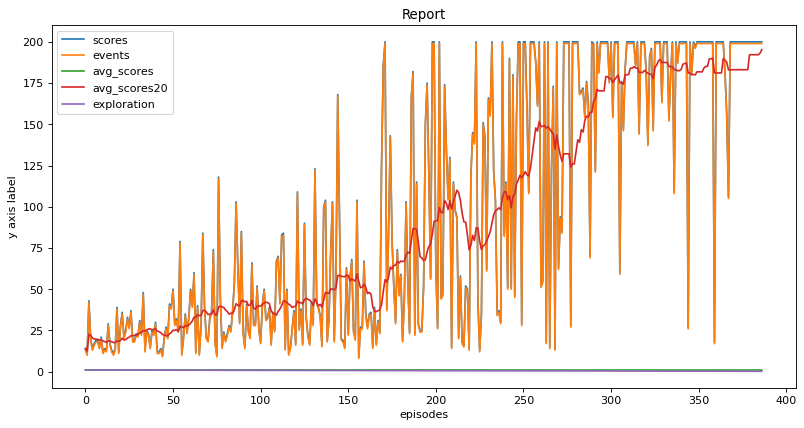

Could not find video


In [7]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=2000
MaxSteps=200
FreezeCounter=25
BatchSize=128
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=9999999
LearningRateDecay=0.97


arch = "DQN"

#network DQN


buffer = ReplayBuffer(1000000, inputs,device);

# print(policy_net)

for n_layers in [0]:
    policy_net, target_net = archs.archs(arch,inputs,n_actions,discount_factor,device,n_layers)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    file_path_ = mt.create_dir("results","N"+str(n_layers)+"_Layers")
    for LearningRate in [0.01,0.001, 0.0001]:
        optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=LearningRateDecay)
        loss = torch.nn.MSELoss()
        def trainModel():
            if buffer.counter < BatchSize:
                return 0.0
            
            state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

            q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
            with torch.no_grad():
                q_max_next = target_net(new_state_batch).max(1)[0].detach()
            q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

            ll=loss(q_actual, q_target.unsqueeze(1))

            # Optimize the model
            optimizer.zero_grad()
            ll.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()

            return ll.item();
        file_name = mt.set_name(arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,LearningRate,LearningRateDecay)
        file_path = mt.create_dir(file_path_,file_name)
        mt.create_dir(file_path,"Checkpoints")
        print(file_name)
        bestNet, episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100 = tl.train_loop(policy_net, target_net, env, device, TotalEpisodes, FreezeCounter, SaveAtCounter, createMovie, MaxSteps, exploration_threshold, exploration_decay, exploration_threshold_min, buffer, trainModel,file_path)

        eval.performance_evaluation(file_path,episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100)
        eval.report(file_path,arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,
                    LearningRate,LearningRateDecay,episodes, scores, events, avg_scores, avg_scores20, exploration, n_layers,avg_scores100)
        createMovie(bestNet,file_path,'bestNet')
        time.sleep(1)